### Libraries

In [1]:
# basic 
import joblib
import pandas as pd
import numpy as np
import datetime, time
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50, 'display.max_rows', 200)


# plot

import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
%matplotlib inline

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)


# models
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from bayes_opt import BayesianOptimization
from sklearn.ensemble import VotingClassifier
from vecstack import StackingTransformer
from vecstack import stacking

## Read Transactions & Simple Preprocessing

##### Read transactions

In [2]:
#bow한 데이터 호출
data = joblib.load('bow_data.pkl')
locals().update(data)

In [4]:
X_train = pd.read_csv('X_train.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949')
tr = pd.merge(X_train, y_train, on='cust_id')
tr = tr[['cust_id', 'gender', 'tran_date', 'store_nm','goods_id','gds_grp_nm','gds_grp_mclas_nm','amount']]

X_test = pd.read_csv('X_test.csv', encoding='cp949')
tr2 = X_test

trs = [tr, tr2]

In [5]:
df3=pd.read_csv('X_train_after_corr.csv',encoding='cp949')
X_test=pd.read_csv('X_test_after_corr.csv',encoding='cp949')

# 구매 다양성이라는 변수추가

In [6]:
tu = tr.groupby('cust_id')['gds_grp_mclas_nm'].agg([
    ('구매다양성', lambda x: len(x.value_counts())/49)
]).reset_index()
td=tr2.groupby('cust_id')['gds_grp_mclas_nm'].agg([
    ('구매다양성', lambda x: len(x.value_counts())/49)
]).reset_index()

In [7]:
df3=pd.merge(df3,tu,on='cust_id')
X_test=pd.merge(X_test,td,on='cust_id')

In [8]:
df3.to_csv('X_train_after_corr.csv',index=False, encoding='cp949')
X_test.to_csv('X_test_after_corr.csv', index=False, encoding='cp949')

## ────────────────────────────────────────────────────────

###  피쳐 전처리

In [9]:
# 추가 라이브러리
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile
from sklearn.linear_model import LogisticRegression
from scipy.stats.mstats import gmean
from sklearn.preprocessing import MinMaxScaler

In [10]:
train = pd.read_csv('X_train_after_corr.csv',encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender
test = pd.read_csv('X_test_after_corr.csv', encoding='cp949')

train_test = pd.concat([train, test], ignore_index=True)


<font color = 'blue'> 이상치 제거

In [11]:
train_test.iloc[:,1:] = train_test.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

<font color = 'blue'> 로그변환

In [12]:
train_test.iloc[:,1:] = np.log1p(train_test.iloc[:,1:])

<font color = 'blue'> MinMaxScaling

In [13]:
X_train = train_test[:3500]
X_test = train_test[3500:]

scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

train_test = pd.concat([X_train, X_test], ignore_index=True)

<font color = 'blue'> PCA

In [14]:
max_col = train_test.shape[1]
pca = PCA(n_components=max_col, random_state=0).fit(train_test)

cumsum = np.cumsum(pca.explained_variance_ratio_)
num_col = np.argmax(cumsum >= 0.99) + 1

# num_col 이 1이었기 때문에 num_col은 max_col이 되었다

if num_col == 1:
    num_col = max_col

pca = PCA(n_components = num_col, random_state=0).fit_transform(train_test)
train_test = pd.DataFrame(pca)

# pca한 데이터와 bow데이터를 병합

In [15]:
cp=pd.DataFrame({'cust_id':np.arange(0,5982)})

In [16]:
cx=pd.concat([X_train_bow_sel,X_test_bow_sel])
cx['cust_id']=cp['cust_id']
train_test['cust_id']=cp['cust_id']
cx=pd.merge(cp,cx,on='cust_id')
train_test=pd.merge(cp,train_test,on='cust_id')

In [17]:
train_test=pd.merge(train_test,cx,on='cust_id')
train_test=train_test[train_test.columns[1:]]

In [18]:
X_train = train_test[:3500]
X_test = train_test[3500:]

<font color = 'blue'> Select Features
    - 여러 모델을 사용하여 가장 잘나온 p를 선택

In [19]:
logreg = LogisticRegression(random_state=0, n_jobs=-1)
rf = RandomForestClassifier(random_state=0, n_jobs=-1)
extra = ExtraTreesClassifier(random_state=0, n_jobs=-1)
gbm = GradientBoostingClassifier(random_state=0)
lgbm = LGBMClassifier(random_state=0 ,n_jobs=-1)
xgb = XGBClassifier(random_state=0 ,n_jobs=-1)

models = [logreg, rf, extra, gbm, lgbm, xgb]

100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [04:06<00:00,  3.28s/it]
No handles with labels found to put in legend.
  0%|                                                                                           | 0/75 [00:00<?, ?it/s]

LogisticRegression (25, 0.7677449922831097)


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [07:05<00:00,  5.67s/it]
No handles with labels found to put in legend.
  0%|                                                                                           | 0/75 [00:00<?, ?it/s]

RandomForestClassifier (39, 0.7547513251577882)


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [03:53<00:00,  3.11s/it]
No handles with labels found to put in legend.
  0%|                                                                                           | 0/75 [00:00<?, ?it/s]

ExtraTreesClassifier (44, 0.752643088426154)


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [57:53<00:00, 46.31s/it]
No handles with labels found to put in legend.
  0%|                                                                                           | 0/75 [00:00<?, ?it/s]

GradientBoostingClassifier (24, 0.7586185605701699)


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [10:23<00:00,  8.31s/it]
No handles with labels found to put in legend.
  0%|                                                                                           | 0/75 [00:00<?, ?it/s]

LGBMClassifier (53, 0.7511469424111346)


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [16:52<00:00, 13.49s/it]
No handles with labels found to put in legend.


XGBClassifier (37, 0.7443506828704686)


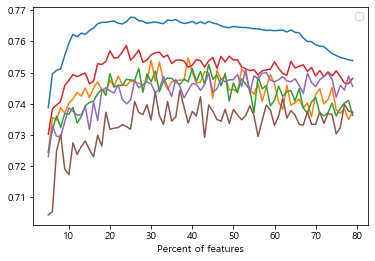

In [20]:
# 6개의 모델을 이용해서 가장 잘나온 p를 뽑을 것임
for model in models:
    
    cv_scores = []
    
    # 퍼센타일을 5~100프로 모두 살피기
    for percentile in tqdm(range(5,80)):
    
        X_new = SelectPercentile(percentile = percentile).fit_transform(X_train,y_train)
       
        # cross_val_score 5번의 평균값
        cv_score = cross_val_score(model, X_new, y_train, scoring='roc_auc', cv=5).mean()
        
        cv_scores.append((percentile, cv_score))
        
    # 베스트 percentile과 점수 출력
    best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
    print(model.__class__.__name__, best_score)
    
    # 모델별 percentile에 따른 성능 그림
    plt.plot([p for p,_ in cv_scores], [score for _, score in cv_scores])
    plt.xlabel('Percent of features')
    plt.legend(loc=0)
    plt.grid()

 17%|██████████████                                                                      | 1/6 [00:03<00:19,  3.96s/it]

[0.7567323  0.71411543 0.77528256 0.76392792 0.76748853] 0.7555093481896876


 33%|████████████████████████████                                                        | 2/6 [00:05<00:12,  3.20s/it]

[0.77334227 0.72591381 0.78925616 0.77615265 0.76787948] 0.7665088737580946


 50%|██████████████████████████████████████████                                          | 3/6 [00:07<00:08,  2.91s/it]

[0.76712984 0.73105602 0.79310195 0.77397743 0.76439568] 0.7659321846114401


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:09<00:05,  2.73s/it]

[0.76831316 0.73448417 0.78976951 0.77650938 0.76516889] 0.7668490238175977


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:12<00:02,  2.79s/it]

[0.77262879 0.73742506 0.7806597  0.77751869 0.7600344 ] 0.7656533294727534


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:18<00:00,  3.04s/it]
No handles with labels found to put in legend.
  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

[0.777684   0.73205663 0.7766486  0.77114965 0.74230261] 0.7599682968875255
LogisticRegression (34, 0.7668490238175977)


 17%|██████████████                                                                      | 1/6 [00:03<00:16,  3.21s/it]

[0.7277758  0.70434    0.76655994 0.73099512 0.75527349] 0.7369888675569147


 33%|████████████████████████████                                                        | 2/6 [00:07<00:14,  3.57s/it]

[0.73829515 0.7223247  0.7781582  0.73703352 0.75217629] 0.745597573328963


 50%|██████████████████████████████████████████                                          | 3/6 [00:12<00:11,  3.98s/it]

[0.72924624 0.73384465 0.79592538 0.75670185 0.75130317] 0.7534042591671695


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:17<00:08,  4.28s/it]

[0.72471744 0.72017558 0.79419826 0.74002662 0.7438447 ] 0.7445925204991242


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:23<00:04,  4.80s/it]

[0.74770079 0.71691711 0.79436357 0.74670889 0.74596018] 0.7503301091780281


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.04s/it]
No handles with labels found to put in legend.
  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

[0.73317469 0.72177219 0.77835397 0.7278193  0.74068668] 0.7403613667396629
RandomForestClassifier (32, 0.7534042591671695)


 17%|██████████████                                                                      | 1/6 [00:02<00:11,  2.35s/it]

[0.73950022 0.70781599 0.75950353 0.73197832 0.74559529] 0.7368786698370692


 33%|████████████████████████████                                                        | 2/6 [00:04<00:09,  2.44s/it]

[0.73870409 0.71914888 0.78166465 0.74288051 0.74438334] 0.7453562949632927


 50%|██████████████████████████████████████████                                          | 3/6 [00:07<00:07,  2.59s/it]

[0.72638801 0.7242824  0.79089193 0.73373154 0.74392723] 0.7438442206002428


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:10<00:05,  2.70s/it]

[0.72975524 0.73199137 0.78954329 0.74252378 0.74758479] 0.7482796944790027


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:13<00:02,  2.82s/it]

[0.72672734 0.73514979 0.78045523 0.74117079 0.74780199] 0.7462610266266128


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.89s/it]
No handles with labels found to put in legend.
  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

[0.7213154  0.73662023 0.77286807 0.72255962 0.73206405] 0.7370854737537619
ExtraTreesClassifier (34, 0.7482796944790027)


 17%|██████████████                                                                      | 1/6 [00:09<00:49,  9.81s/it]

[0.74567784 0.72011033 0.77095388 0.73303112 0.75950445] 0.7458555232800025


 33%|████████████████████████████                                                        | 2/6 [00:32<00:54, 13.55s/it]

[0.7527821  0.72576589 0.78016375 0.75807223 0.75631603] 0.7546200021356929


 50%|██████████████████████████████████████████                                          | 3/6 [01:08<01:01, 20.35s/it]

[0.75290392 0.73621564 0.7786324  0.76085651 0.7541267 ] 0.756547034447476


 67%|████████████████████████████████████████████████████████                            | 4/6 [01:46<00:51, 25.57s/it]

[0.74920605 0.72608783 0.78688082 0.7587161  0.75724562] 0.7556272833395798


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [02:32<00:31, 31.74s/it]

[0.75010224 0.72898522 0.78270441 0.75339117 0.74358841] 0.7517542859726061


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:52<00:00, 38.71s/it]
No handles with labels found to put in legend.
  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

[0.76183971 0.72689701 0.77722286 0.74797922 0.73820197] 0.7504281543857114
GradientBoostingClassifier (32, 0.756547034447476)


 17%|██████████████                                                                      | 1/6 [00:02<00:10,  2.06s/it]

[0.7377905  0.70336115 0.75706728 0.72355587 0.74917466] 0.7341898926902526


 33%|████████████████████████████                                                        | 2/6 [00:06<00:10,  2.66s/it]

[0.73533685 0.71655167 0.77095823 0.74634346 0.74813212] 0.7434644667540512


 50%|██████████████████████████████████████████                                          | 3/6 [00:12<00:11,  3.69s/it]

[0.73629395 0.72150247 0.77099303 0.75307793 0.74167709] 0.7447088946638946


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:18<00:09,  4.58s/it]

[0.74033116 0.72248567 0.77557839 0.74701343 0.74132958] 0.7453476433383932


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:27<00:05,  5.72s/it]

[0.75828976 0.72054537 0.76529396 0.75025015 0.73652523] 0.7461808931190387


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:40<00:00,  6.75s/it]
No handles with labels found to put in legend.
  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

[0.74980641 0.72737556 0.77305514 0.75836806 0.74033048] 0.7497871293668611
LGBMClassifier (68, 0.7497871293668611)


 17%|██████████████                                                                      | 1/6 [00:03<00:19,  3.85s/it]

[0.72554837 0.69835815 0.73605033 0.71208812 0.72335453] 0.7190798995328348


 33%|████████████████████████████                                                        | 2/6 [00:11<00:19,  4.92s/it]

[0.73012503 0.70257807 0.76646858 0.73840826 0.72324159] 0.7321643058963951


 50%|██████████████████████████████████████████                                          | 3/6 [00:21<00:19,  6.61s/it]

[0.71998851 0.71544666 0.7647284  0.74037466 0.7405303 ] 0.7362137078030744


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:32<00:15,  7.97s/it]

[0.73803412 0.71893571 0.75865519 0.74663059 0.74145121] 0.7407413647158452


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:46<00:09,  9.71s/it]

[0.73399692 0.70758107 0.75638427 0.7258094  0.72229462] 0.7292132549628048


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:09<00:00, 11.51s/it]
No handles with labels found to put in legend.


[0.75083311 0.70631944 0.76461529 0.73611993 0.72980956] 0.7375394679338214
XGBClassifier (34, 0.7407413647158452)


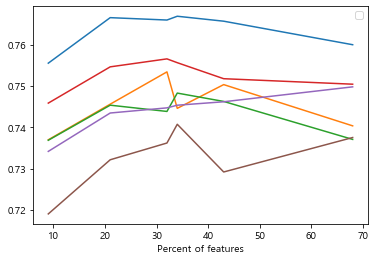

In [21]:
# 6개의 모델을 이용해서 가장 잘나온 p를 뽑을 것임

new_range = [9, 21, 32, 34, 43, 68]

for model in models:
    
    cv_scores_mean = []
    
    
    # 퍼센타일을 5~100프로 모두 살피기
    for percentile in tqdm(new_range):
    
        X_new = SelectPercentile(percentile = percentile).fit_transform(X_train,y_train)
       
        # cross_val_score 5번의 평균값
        cv_score = cross_val_score(model, X_new, y_train, scoring='roc_auc', cv=5)
        
        cv_scores_mean.append((percentile, cv_score.mean()))
        
        print(cv_score, cv_score.mean())
        
        # 베스트 percentile과 점수 출력
    best_score = cv_scores_mean[np.argmax([score for _, score in cv_scores_mean])]
    print(model.__class__.__name__, best_score)
    
    # 모델별 percentile에 따른 성능 그림
    plt.plot([p for p,_ in cv_scores_mean], [score for _, score in cv_scores_mean])
    plt.xlabel('Percent of features')
    plt.legend(loc=0)
    plt.grid()

In [22]:
select_p = SelectPercentile(percentile = 32).fit(X_train, y_train)
X_train = select_p.transform(X_train)
X_test = select_p.transform(X_test)

In [24]:
X_tr=pd.DataFrame(X_train)
X_te=pd.DataFrame(X_test)

In [25]:
bow_plus={
    'X_tr':X_tr,
    'X_te':X_te
}
joblib.dump(bow_plus,'bow_plus.pkl')

['bow_plus.pkl']

# End